# Caderno 4 - Calcula métricas considerando os resultados de pesquisa em um BM25 padrão

In [1]:
# Se True, refaz a indexação. Se False, tenta recuperar o
# índice do arquivo indice_js_enunciado_e_excerto.pickle.
# É necessário que esse arquivo exista.
REINDEXAR_ENUNCIADO_EXCERTO = False

## 1. Carrega base de dados

In [2]:
import pandas as pd

PASTA_DADOS = './dados/'
PASTA_JS = f'{PASTA_DADOS}originais/jurisprudencia_selecionada/'
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

queries = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
qrels = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

def carrega_jurisprudencia_selecionada():
    js_parte_1 = pd.read_csv(f'{PASTA_JS}jurisprudencia-selecionada-parte-1.csv', sep='|')
    js_parte_2 = pd.read_csv(f'{PASTA_JS}jurisprudencia-selecionada-parte-2.csv', sep='|')
    js_parte_3 = pd.read_csv(f'{PASTA_JS}jurisprudencia-selecionada-parte-3.csv', sep='|')
    js_parte_4 = pd.read_csv(f'{PASTA_JS}jurisprudencia-selecionada-parte-4.csv', sep='|')
    
    js_restaurado = pd.concat([js_parte_1, js_parte_2, js_parte_3, js_parte_4], ignore_index=True)

    return js_restaurado

js = carrega_jurisprudencia_selecionada()

## 2. Instancia um BM25 e indexa os campos ENUNCIADO e EXCERTO

In [3]:
from bm25 import IndiceInvertido, BM25, tokenizador_pt
import re

# Função para remover tags HTML
def remove_html(html):
  return re.sub("<[^>]*>", "", html).strip()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [4]:
# Vamos criar um índice invertido e indexar apenas o enunciado e excerto.
iidx = IndiceInvertido(lambda texto: tokenizador_pt(remove_html(texto)))
if REINDEXAR_ENUNCIADO_EXCERTO:
    # Se for indexar a primeira vez:
    # Demora cerca de 35 minutos para indexar
    iidx.adiciona_dataframe(js, lambda row: (row['KEY'], row['ENUNCIADO'] + ' ' + row['EXCERTO']))
else:
    # Se quiser recuperar de um arquivo:
    iidx.from_pickle('indice_js_enunciado_e_excerto.pickle')

In [5]:
iidx.to_pickle('indice_js_enunciado_e_excerto.pickle')

In [6]:
# Agora instancia um BM25
buscador = BM25(iidx, k1=0.82, b=0.68, bias_idf=1)

## 3. Faz as pesquisas e salva os resultados

In [7]:
col_resultado_query_key=[]
col_resultado_doc_key=[]
col_resultado_rank=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    resultados = buscador.pesquisar(query_text)

    primeiros_50_docs = [tupla_key_score[0] for tupla_key_score in resultados[:50]]
    queries_keys = [query_key] * len(primeiros_50_docs)
    ranking = list(range(1, len(primeiros_50_docs)+1))

    col_resultado_query_key.extend(queries_keys)
    col_resultado_doc_key.extend(primeiros_50_docs)
    col_resultado_rank.extend(ranking)

df_resultados = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key,
    "DOC_KEY": col_resultado_doc_key,
    "RANK": col_resultado_rank,
})

In [8]:
from metricas import metricas

df_metricas = metricas(df_resultados, qrels, aproximacao_trec_eval=True)

,QUERY_KEY,P@5,P@10,P@50,R@5,R@10,R@50,MRR@5,MRR@10,MRR@50,nDCG@5,nDCG@10,nDCG@50
count,50.00000,50.000000,50.000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.264000,0.236,0.119200,0.105646,0.194435,0.489433,0.520333,0.531222,0.538891,0.279184,0.272492,0.418389
std,14.57738,0.237126,0.186,0.055396,0.092290,0.158424,0.251410,0.433324,0.421067,0.411568,0.250454,0.221211,0.226182
min,1.00000,0.000000,0.000,0.020000,0.000000,0.000000,0.066667,0.000000,0.000000,0.022222,0.000000,0.000000,0.027396
25%,13.25000,0.050000,0.100,0.065000,0.016667,0.071429,0.254167,0.050000,0.133333,0.133333,0.032801,0.088068,0.231162
50%,25.50000,0.200000,0.200,0.120000,0.083333,0.160256,0.461538,0.333333,0.333333,0.333333,0.220047,0.229854,0.412747
75%,37.75000,0.400000,0.375,0.160000,0.151099,0.296429,0.698077,1.000000,1.000000,1.000000,0.470365,0.432569,0.601052
max,50.00000,1.000000,0.700,0.200000,0.384615,0.545455,0.909091,1.000000,1.000000,1.000000,0.991365,0.827036,0.806014


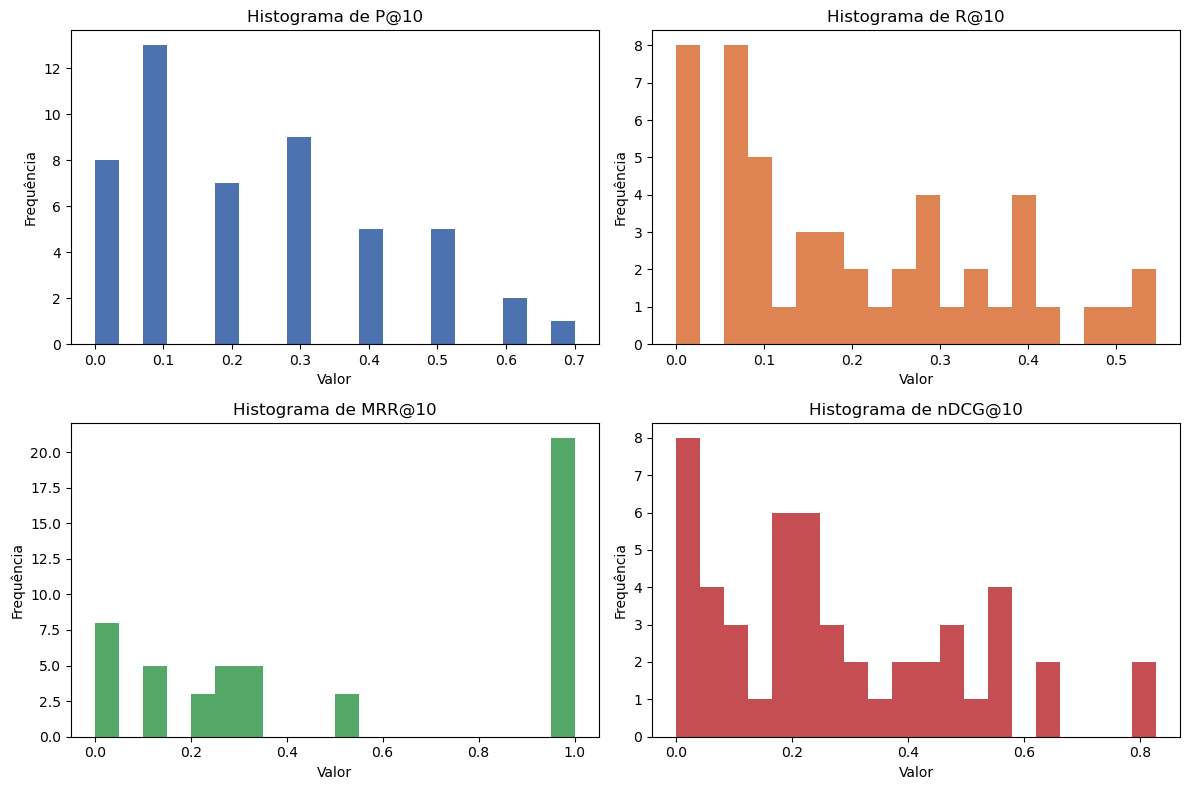

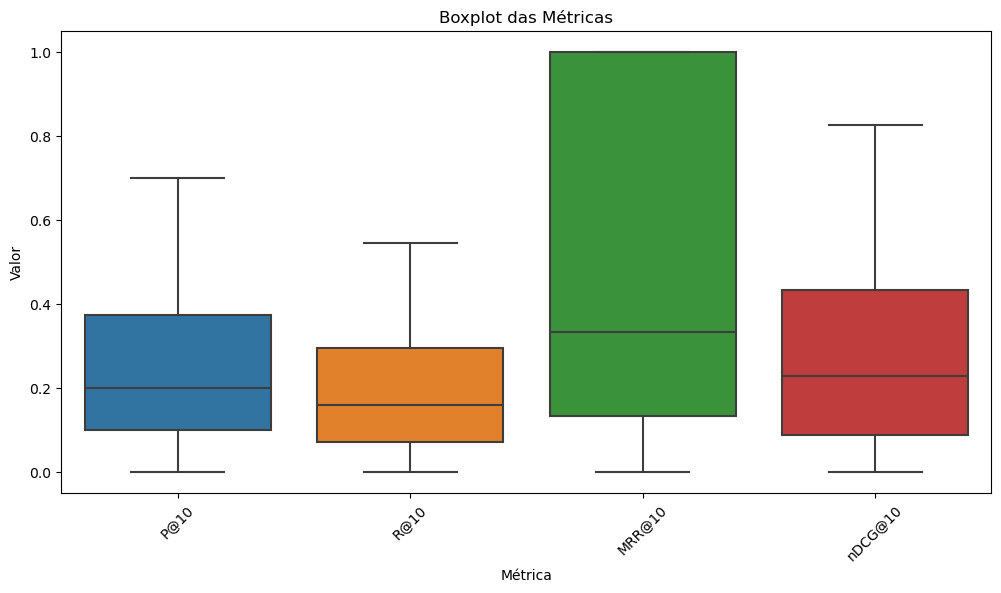

In [9]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries:
display(df_metricas[0:50].describe())
histograma_metricas(df_metricas[0:50])
boxplot_metricas(df_metricas[0:50])

,QUERY_KEY,P@5,P@10,P@50,R@5,R@10,R@50,MRR@5,MRR@10,MRR@50,nDCG@5,nDCG@10,nDCG@50
count,50.00000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.508000,0.36800,0.137200,0.213552,0.310163,0.570953,0.860000,0.867556,0.867556,0.580879,0.505807,0.613022
std,14.57738,0.265607,0.19319,0.049489,0.116326,0.176427,0.222806,0.299489,0.278205,0.278205,0.242035,0.187163,0.178556
min,51.00000,0.000000,0.10000,0.020000,0.000000,0.071429,0.083333,0.000000,0.100000,0.100000,0.000000,0.051685,0.122265
25%,63.25000,0.400000,0.20000,0.105000,0.145604,0.178571,0.428571,1.000000,1.000000,1.000000,0.460825,0.388955,0.535449
50%,75.50000,0.400000,0.30000,0.140000,0.214286,0.279221,0.577381,1.000000,1.000000,1.000000,0.632660,0.532875,0.627466
75%,87.75000,0.800000,0.50000,0.180000,0.305769,0.412500,0.750000,1.000000,1.000000,1.000000,0.724738,0.628982,0.704134
max,100.00000,1.000000,0.70000,0.200000,0.454545,0.700000,1.000000,1.000000,1.000000,1.000000,1.000000,0.832815,0.941661


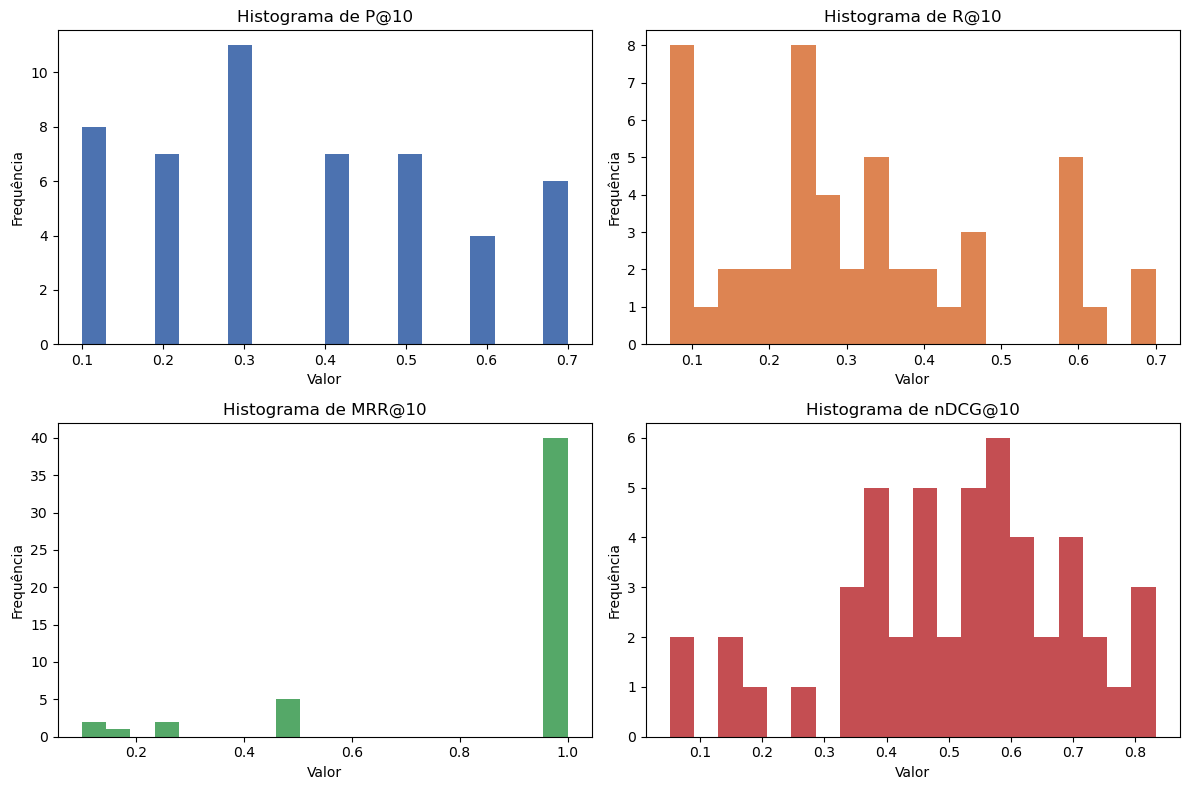

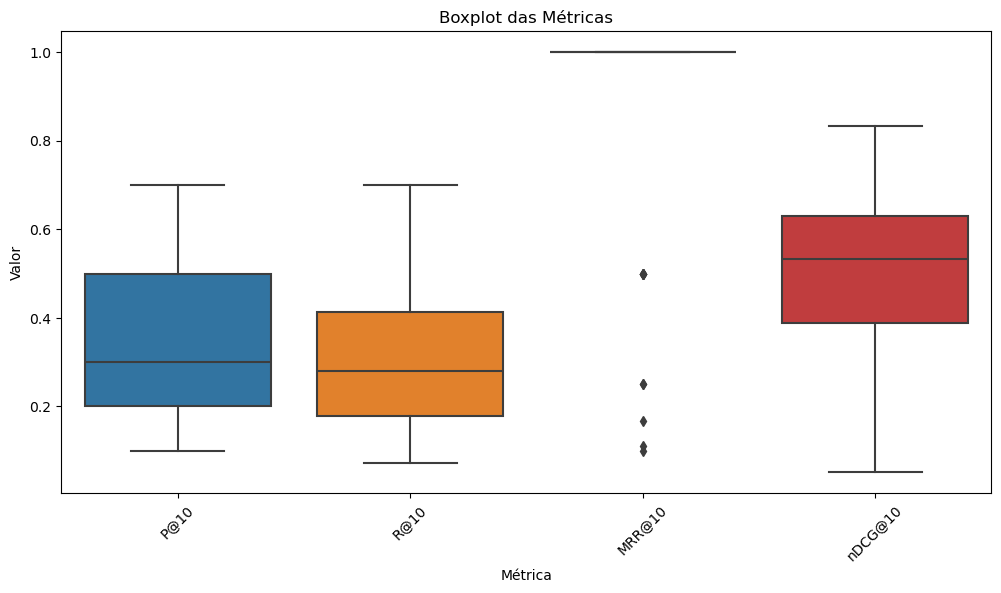

In [10]:
# Resultados para o primeiro grupo de queries:
display(df_metricas[50:100].describe())
histograma_metricas(df_metricas[50:100])
boxplot_metricas(df_metricas[50:100])

,QUERY_KEY,P@5,P@10,P@50,R@5,R@10,R@50,MRR@5,MRR@10,MRR@50,nDCG@5,nDCG@10,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.508000,0.366000,0.134400,0.228620,0.325582,0.592057,0.909000,0.911222,0.911222,0.592258,0.513554,0.623440
std,14.57738,0.249767,0.177982,0.052998,0.120354,0.158596,0.232188,0.238552,0.230286,0.230286,0.213754,0.172147,0.172034
min,101.00000,0.000000,0.100000,0.020000,0.000000,0.066667,0.100000,0.000000,0.111111,0.111111,0.000000,0.070969,0.268529
25%,113.25000,0.400000,0.200000,0.085000,0.153846,0.207692,0.454545,1.000000,1.000000,1.000000,0.482053,0.432999,0.477703
50%,125.50000,0.400000,0.350000,0.140000,0.218254,0.333333,0.625874,1.000000,1.000000,1.000000,0.589126,0.496699,0.637923
75%,137.75000,0.600000,0.500000,0.180000,0.300000,0.452020,0.750000,1.000000,1.000000,1.000000,0.737082,0.661128,0.760916
max,150.00000,1.000000,0.700000,0.220000,0.500000,0.636364,1.000000,1.000000,1.000000,1.000000,1.000000,0.801233,0.927799


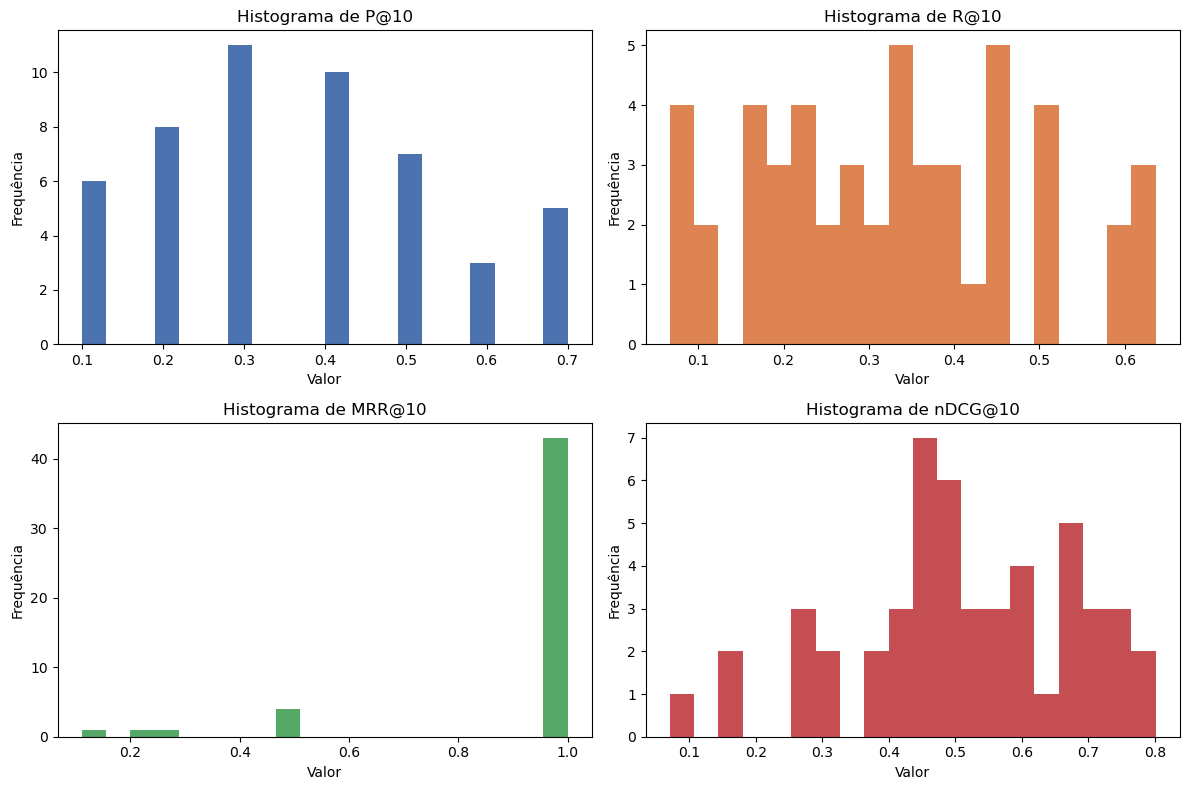

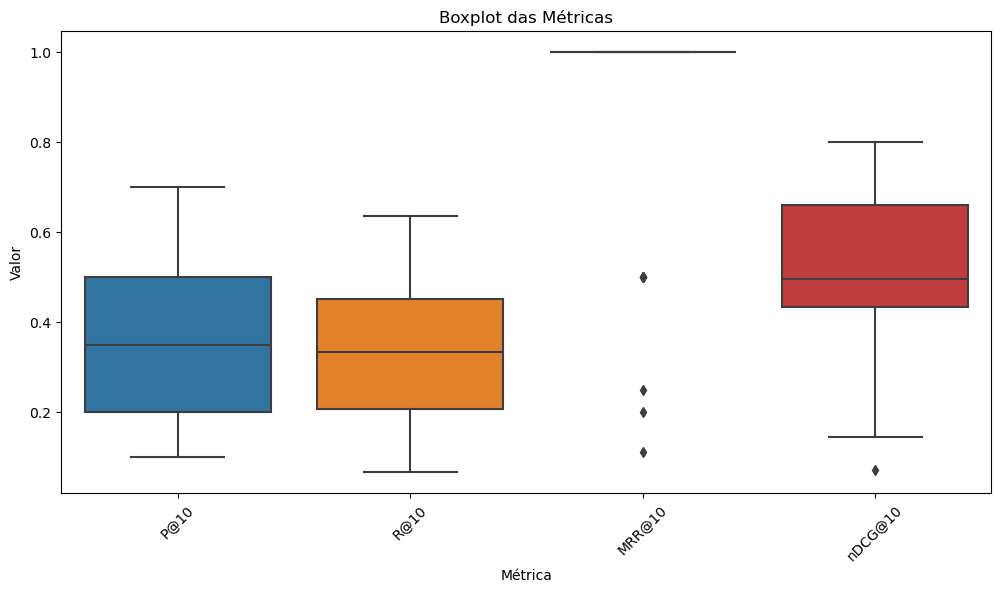

In [11]:
# Resultados para o primeiro grupo de queries:
display(df_metricas[100:150].describe())
histograma_metricas(df_metricas[100:150])
boxplot_metricas(df_metricas[100:150])